<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CMC-Dataset." data-toc-modified-id="CMC-Dataset.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CMC Dataset.</a></span></li><li><span><a href="#Feature-Engineering-and-Model-evaluation-+-validation" data-toc-modified-id="Feature-Engineering-and-Model-evaluation-+-validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Engineering and Model evaluation + validation</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Features-importance" data-toc-modified-id="Features-importance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Features importance</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Correlation?" data-toc-modified-id="Correlation?-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Correlation?</a></span></li></ul></li><li><span><a href="#information-gain" data-toc-modified-id="information-gain-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>information gain</a></span></li><li><span><a href="#Features-creation" data-toc-modified-id="Features-creation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Features creation</a></span></li><li><span><a href="#Remove-outliers" data-toc-modified-id="Remove-outliers-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Remove outliers</a></span></li><li><span><a href="#Recursive-feature-elimination" data-toc-modified-id="Recursive-feature-elimination-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Recursive feature elimination</a></span></li><li><span><a href="#Validate-model-parameters" data-toc-modified-id="Validate-model-parameters-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Validate model parameters</a></span></li></ul></div>

# CMC Dataset.

Let's play with a simple pipeline to build a classifier on the CMC dataset. **Our goal** is to improve the baseline with feature engineering techniques or model tunning, but not by changing the model algorithm.

Data Set Information:

This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview. The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

Attribute Information:

1. Wife's age (numerical)
2. Wife's education (categorical) 1=low, 2, 3, 4=high
3. Husband's education (categorical) 1=low, 2, 3, 4=high
4. Number of children ever born (numerical)
5. Wife's religion (binary) 0=Non-Islam, 1=Islam
6. Wife's now working? (binary) 0=Yes, 1=No
7. Husband's occupation (categorical) 1, 2, 3, 4
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high
9. Media exposure (binary) 0=Good, 1=Not good
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term

In [24]:
# Headers 
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from copy import copy
from collections import Counter
from dataset import Dataset as dataset
from gplearn.genetic import SymbolicTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss
from math import log2
from scipy import stats
from scipy.stats import kruskal
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from tqdm import tqdm_notebook
from typing import List


# This line is important if you want your results to be reproducible
np.random.seed(555)

# Feature Engineering and Model evaluation + validation

Let's work on the dataset we've been using during the model evaluation and evaluation notebook

# Data preparation

Let's put all the lines of code involved in loading the dataset, in a function, so we can call it later throughout this process.

In [2]:
def init_dataset(onehot=True, discretize=True):
    URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data'
    df = dataset(URL, header=None)
    df.to_int()
    df.drop_na()
    df.set_target('x9')
    df.to_numerical(df.categorical_features)

    # Binomize and categorical
    df.drop_samples(df.samples_matching(3))
    df = df.to_categorical(['x1', 'x2', 'x4', 'x5', 'x6', 'x7', 'x8'])
    
    return df

This other class will serve me to evaluate my dataset at any point. It will also store the results obtained, so we can see how our process goes. 

In [3]:
class validate:

    train_f1 = []
    test_f1 = []

    def this(self, df,
             C=1.0, penalty='l2', solver='lbfgs',  # LR Parameters
             keep=True,                           # store this evaluation?
             silent=False,                        # print results?
             plot=False):                         # plot historic evaluations?
        #
        # Repeat 10 times
        #   split training and test,
        #     evaluate, through CV (k-fold [20]) performance in training
        #   evaluate, with test set
        # take the median of the test set evaluations
        #
        test_f1 = []
        for i in range(10):
            X, y = df.split(seed=i*23)
            training_F1, F1_scores, F1_std = self.evaluate_cv(
                X.train, y.train,
                C, penalty, solver)
            test_f1.append(self.evaluate(X.train, y.train, X.test, y.test,
                                         C, penalty, solver))
        test_F1 = np.median(test_f1)

        if silent == False:
            print('CV Training F1: {:.4f}'.format(training_F1))
            print('Test F1: {:.4f}'.format(test_F1))

        if keep is True:
            self.train_f1.append(training_F1)
            self.test_f1.append(test_F1)

        if plot is True:
            self.plot()

        # return the medians of the training performance on each k-fold eval.
        # and the median of the test set evaluations.
        return training_F1, test_F1

    def evaluate_cv(self, X_train, y_train, C, penalty, solver):
        my_model = LogisticRegression(C=C, penalty=penalty, solver=solver)
        cv_scores = cross_val_score(
            my_model, X_train, y_train, scoring='f1', cv=10)
        med = np.median(cv_scores)
        std = np.std(cv_scores)

        return med, cv_scores, std

    def evaluate(self, X_train, y_train, X_test, y_test, C, penalty, solver):
        my_model = LogisticRegression(C=C, penalty=penalty, solver=solver)
        my_model.fit(X_train, y_train)
        y_hat = my_model.predict(X_test)
        F1 = f1_score(y_test, y_hat)
        return F1

    def plot(self):
        num_items = len(self.train_f1)
        plt.figure(figsize=(8, 6))
        plt.plot(range(num_items), self.train_f1,
                 marker='.', label='F1 training')
        plt.plot(range(num_items), self.test_f1, marker='.', label='F1 test')
        plt.xticks(range(num_items), range(num_items))
        plt.legend(loc='best')
        plt.show()

# I simply create an object from this class. From now on, I will use that
# object to evaluate my model.
validate = validate()

# Baseline

Once variables are ready to be fed into an __estimator__ (Logistic Regression in our case), we must establish what is the baseline of our dataset. This will the bar we must rise.

In [4]:
df = init_dataset(onehot=False, discretize=False)
df.describe()

9 Features. 962 Samples
Available types: [dtype('int64') dtype('O')]
  · 7 categorical features
  · 2 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 9 Complete features
--
Target: x9 (int64)
'x9'
  · Min.: 1.0000
  · 1stQ: 1.0000
  · Med.: 1.0000
  · Mean: 1.3462
  · 3rdQ: 2.0000
  · Max.: 2.0000


How does the dataset looks like?

In [5]:
df.features.head(4)

,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0


In [6]:
df = df.to_numerical(df.categorical_features)

print('Baseline\n--------')
baseline_F1, test_F1 = validate.this(df)

Baseline
--------
CV Training F1: 0.8114
Test F1: 0.7902


# Features importance

I will estimate what is the optimal number of features to be kept to better solve our problem. Remeber that, sometimes, more feature means more noise. In those cases, we're not helping our method by supplying all the variables. On the contrary, sometimes is useful to get rid of some of them. Which ones? Impossible to know beforehand, so try keeping 1, 2, 3, ... up to the total number of features

In [7]:
f1_importance = []
best = {}

for num in tqdm_notebook(range(1, len(df.names()))):
    # I copy my dataset to another one, as I will be transforming it, and I 
    # want to keep the original
    df2 = df.all.copy(deep=True)
    df2 = dataset.from_dataframe(df2)
    df2.set_target('x9')

    # Discover what are my best feature calling the method `features_importance`
    # which will determine best features using ReliefF algo (seen in class).
    top_features = df2.features_importance(num_features=num)
    df2.keep_columns(list(top_features.keys()))
    # Keep track of what features are selected at each step.
    best[num] = list(top_features.keys())

    # Final step is to evaluate the model with lower nr of features.
    f1_importance.append(validate.this(df2, keep=False, silent=True))

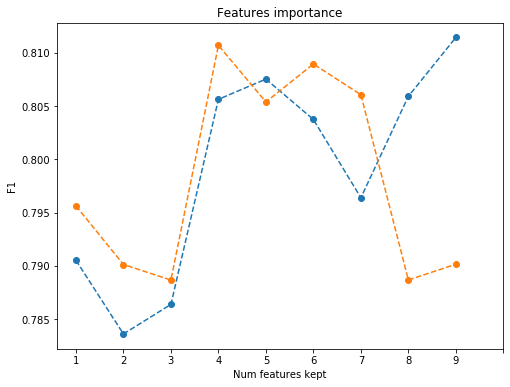

In [8]:
plt.figure(figsize=(8,6))
plt.title('Features importance')
plt.plot(range(len(f1_importance)), f1_importance, '--o')
plt.xticks(range(0, len(df.names())), range(1, len(df.names())))
plt.ylabel('F1')
plt.xlabel('Num features kept')
plt.show()

In [9]:
# Let's keep only 4 as it shows the best F1 in the plot
df.keep_columns(best[4]) 

validate.this(df);

CV Training F1: 0.8056
Test F1: 0.8107


# EDA

This step is here simply to illustrate that sometimes there's low hanging fruit, with under-represented categories, correlations, NAs or features that it better to transform. It is not the case in this quick exercise, but I'm not saying that we could find interesting transformations in our data set that will lead to better F1.

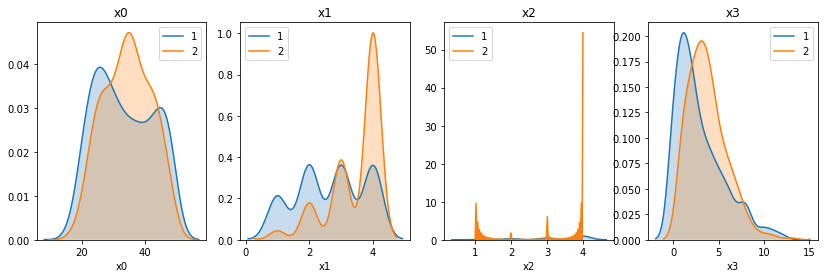

In [10]:
plt.figure(figsize=(14, 4))
num_plots = len(list(df.numerical))
for index, feature in enumerate(list(df.numerical)):
    plt.subplot(1, num_plots, index+1)
    df.plot_double_density(feature)
    plt.legend(loc='best'); plt.ylabel('');
    plt.title(feature)
plt.show();

## Correlation?

We can printout the corr matrix to check that there's no extremely significant correlations. 

Exercise: Try to remove the only high correlation from the dataset to check what is the result.

In [11]:
df.numerical_correlated()[1]

,x0,x1,x2,x3
x0,1.000000,0.062871,0.089042,0.560807
x1,0.062871,1.000000,0.644114,0.134934
x2,0.089042,0.644114,1.000000,0.183079
x3,0.560807,0.134934,0.183079,1.000000


# information gain

If we had categorical variables (we decided to play with only 4 numeric features in the prevous step) we can also use IG to see if there's correlation. I include a subset of commented code just to illustrate the possibility.

In [12]:
# ig = [df.IG(vble) for vble in df.categorical_features]
# 
# plt.plot(range(len(df.categorical_features)), ig, marker='.')
# plt.xticks(range(len(df.categorical_features)), df.categorical_features)
# plt.show()

# df = df.drop_columns(['x4', 'x5'])
# assess(do_onehot(do_discretize(copy(df))))

# Features creation

An example on how to use Genetic Programming for feature creation/construction. Without entering into details, we're using a library that builds new non-linear features from the existing ones, trying to resemble the behavior of the original ones, with regard to the target variable.

You can see how we call the `fit()` method with the features and the target variable. The `transform()` method is giving us the new features.

In [13]:
%%capture

X, y = df.split()

function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 
                'abs', 'neg', 'inv', 'max', 'min']
gp = SymbolicTransformer(generations=25, population_size=1000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005, max_samples=0.9, 
                         verbose=1, random_state=0, n_jobs=3)
gp.fit(df.features, df.target);
gp_features = gp.transform(df.data.values)

# Move the new features at the end of the existing dataframe
df_ext = pd.DataFrame(gp_features)
df_ext.columns = ['gp{}'.format(i) for i in range(len(list(df_ext)))]
df.add_columns(df_ext)

CV Training F1: 0.8152
Test F1: 0.8040


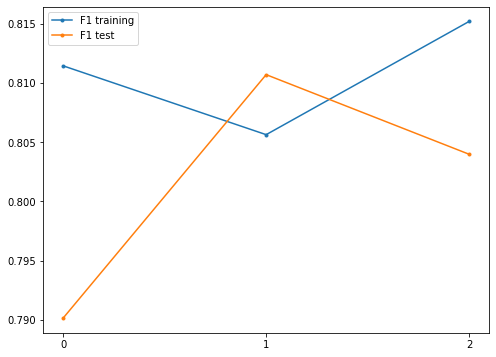

In [14]:
validate.this(df, plot=True);

Desn't seem very obvious that we must preserve this step in our pipeline, since our F1-test is lowering. However, adding these new features will be beneficial in the steps ahead. The only way of knowing this is by experimenting with this stage on and off with several combinations.

We now have all these new features in our dataset.

In [15]:
df.all.head()

,x0,x1,x2,x3,gp0,gp1,gp2,gp3,gp4,gp5,gp6,gp7,gp8,gp9,x9
0,24,2,3,3,2.828427,5.656854,16.0,6.928203,8.0,4.0,3.363586,3.363586,6.727171,11.313708,1
1,45,1,3,10,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1
2,43,2,3,7,2.828427,5.656854,16.0,9.513657,8.0,4.0,3.363586,3.363586,6.727171,11.313708,1
3,42,3,2,9,5.196152,15.588457,81.0,27.000000,27.0,9.0,6.838521,6.838521,20.515564,46.765372,1
4,36,3,3,8,5.196152,15.588457,81.0,25.455844,27.0,9.0,6.838521,6.838521,20.515564,46.765372,1


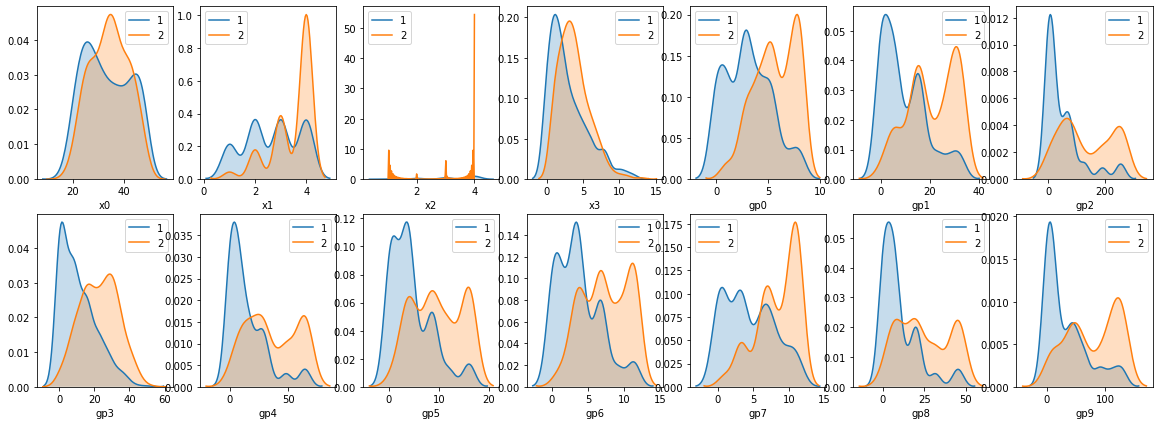

In [16]:
plt.figure(figsize=(20, 7))
num_plots = len(list(df.numerical))
for index, feature in enumerate(list(df.numerical)[:7]):
    plt.subplot(2, 7, index+1)
    df.plot_double_density(feature)
for index, feature in enumerate(list(df.numerical)[7:]):
    plt.subplot(2, 7, index+1+7)
    df.plot_double_density(feature)

plt.show();

Removing any of the features that look pretty similar result in lower F1.

# Remove outliers

This is a very simple step that must be used more often. We've improved our F1-test, although training is lowering a bit.

CV Training F1: 0.8081
Test F1: 0.8090


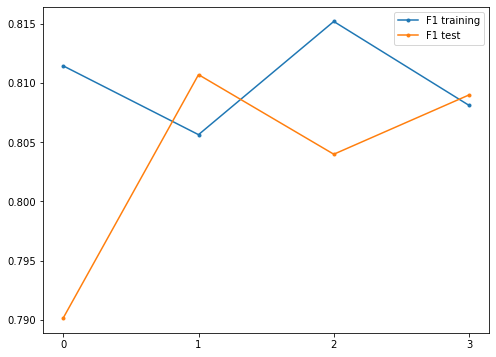

In [17]:
df.drop_samples(df.outliers())

validate.this(df, plot=True);

# Recursive feature elimination

Another way of implementing features selection is using the RFE algorith, which is very similar to the stepwise selection. We're relying here on the scikit-lkearn implementation of RFE.

In [18]:
# A function that calls RFE and returns the best features found
def rfe(ds, num_features):
    estimator = LogisticRegression(random_state=123)
    selector = RFE(estimator, num_features, step=1)
    selector = selector.fit(pd.get_dummies(df.features), df.target)
    return selector.support_

# Loop over the range 3 to 14 features in our dataset and capture results.
df_dummified = pd.get_dummies(df.features)
tst_scores_rfe = []
min_range = 3
max_range = 14
for num_features in tqdm_notebook(range(min_range, max_range)):
    best_features = rfe(df, num_features)
    X = df_dummified[df_dummified.columns[best_features]]
    hdf = dataset.from_dataframe(pd.concat([X, df.target], axis=1))
    hdf.set_target('x9')
    res, _ = validate.this(hdf, keep=False, silent=True)
    tst_scores_rfe.append(res)
    del(hdf)
    del(X)

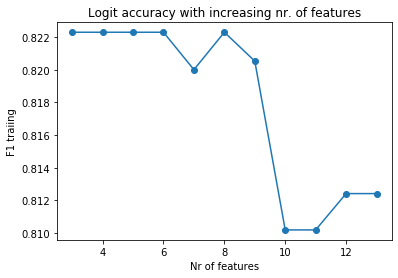

In [19]:
plt.plot(range(min_range, max_range), tst_scores_rfe, 'o-')
plt.title('Logit accuracy with increasing nr. of features')
plt.ylabel('F1 traiing')
plt.xlabel('Nr of features')
plt.show();

Let's keep only 6, and validate results!

CV Training F1: 0.8223
Test F1: 0.8171


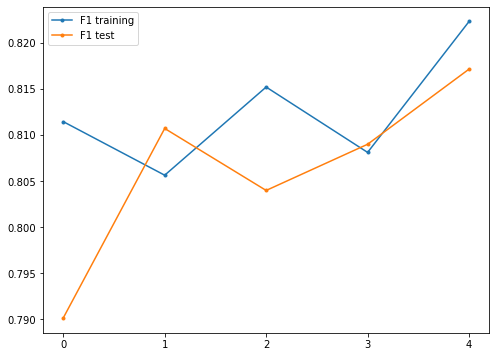

In [20]:
df_dummified = pd.get_dummies(df.features)
best_features = rfe(df, 6)
df_dummified = df_dummified[df_dummified.columns[best_features]]
ddf = dataset.from_dataframe(pd.concat([df_dummified, df.target], axis=1))
ddf.set_target('x9')
validate.this(ddf, plot=True);

# Validate model parameters

Final part of the game is to play with model parameters. We can play with the **regularization** value `C` in Logistic Regression. We will decide what is the best by trying different values.

In [21]:
# Lets build a range of values for C [1.0e-05, 1.0e+05]
n = np.arange(-5, 5, 0.5)
l = np.power(10., n)

# Evaluate the dataset for different values of C.
# We set `keep=False' because we don't want (yet) to store F1 values in the 
# final list of results that tracks our achievements.
f1_tunning = []
for i, c in tqdm_notebook(enumerate(l)):
    f1_tunning.append(validate.this(df, C=c, keep=False, silent=True))

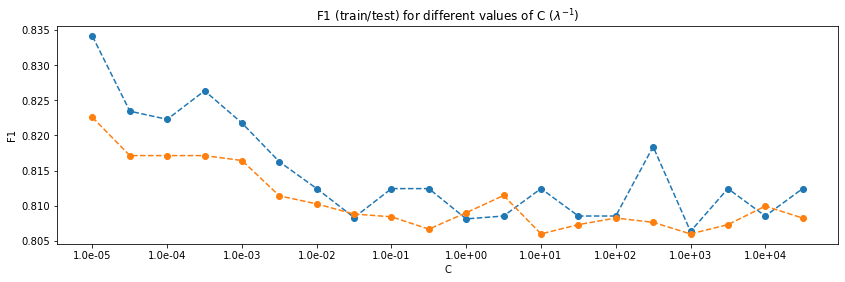

In [22]:
plt.figure(figsize=(14,4))
plt.title('F1 (train/test) for different values of C ($\lambda^{-1})$')
plt.plot(f1_tunning, '--o')
plt.ylabel('F1')
plt.xlabel('C')
plt.xticks(range(0, len(l), 2), ['{:.1e}'.format(v) for v in l[::2]])
plt.show()

We can observe how the best possible value for C (within the range that we've tested is 1.0e-05, which is not the default 1.0 that is passed to the algorithm. So let's finish by tunning this parameter to this value, and see if we achieve an additional gain in our performance.

CV Training F1: 0.8341
Test F1: 0.8226


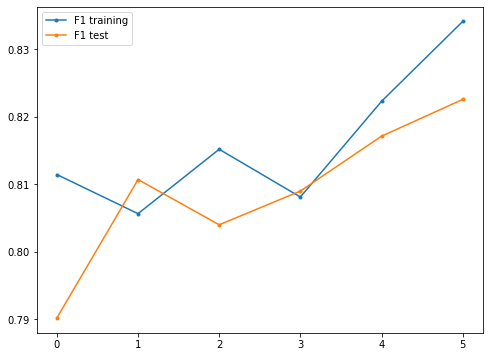

In [23]:
validate.this(df, C=1.0e-05, plot=True);

We've improved results in our process. Sometimes, by simply removing outliers. In a couple of ocasions it is not so obvious that our decision is producing benefits (step 3), as F1-test is decreaing. However, after some iterations, my experiments suggested that this step produces benefits in future steps. That's why it is important to iterate and try different options.